change output to binary list to a single float value, which will be the sum of the target outputs.

In [8]:
import torch
import torch.nn as nn
import math
import pandas as pd
from datetime import datetime as dt, timedelta
from torch.utils.data import Dataset, DataLoader
import os
import torch.optim as optim
import matplotlib.pyplot as plt
import random
import numpy as np
import torch.nn.functional as F
import time


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
seed = 42  # choose any seed you prefer
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

cuda


In [9]:
# hyperparameters for dataset and dataloader
input_size = 20
target_size = 2
batch_size = 16
dropout_rate = 0.2

# hyperparameters for training, testing
learning_rate = 0.0001
num_epochs = 100

In [10]:
class PriceDataset(Dataset):
    def __init__(self, item, timespan, start_date_str, end_date_str, input_window_size, target_window_size):
        self.directory = f'C:/Github/DL-FinalProject/csvfiles/{item}/'
        self.input_window_size = input_window_size
        self.target_window_size = target_window_size
        self.columns = [1, 4]  # Adjust as needed for zero-based indexing in NumPy
        self.data = self.load_data(start_date_str, end_date_str)

    def load_data(self, start_date_str, end_date_str):
        start_date = dt.strptime(start_date_str, '%Y-%m-%d').date()
        end_date = dt.strptime(end_date_str, '%Y-%m-%d').date()
        all_data = []

        for filename in os.listdir(self.directory):
            # Extract date from filename
            file_date_str = '-'.join(filename.split('-')[2:]).split('.')[0]
            file_date = dt.strptime(file_date_str, '%Y-%m-%d').date()

            if start_date <= file_date <= end_date:
                file_path = os.path.join(self.directory, filename)
                # Use NumPy to read the CSV file
                data = np.loadtxt(file_path, delimiter=',', usecols=self.columns, skiprows=1)
                # print(f"Reading file: {filename}, Data shape: {data.shape}")  # Debugging print
                all_data.append(data)

        # Concatenate all data arrays
        combined_data = np.vstack(all_data)
        # print(f"Shape of the combined data: {combined_data.shape}")
        return combined_data

    def __len__(self):
        return len(self.data) - self.input_window_size - self.target_window_size + 1

    def __getitem__(self, idx):
        if idx + self.input_window_size + self.target_window_size > len(self.data):
            raise IndexError("Index out of bounds")

        window_data = self.data[idx:idx + self.input_window_size + self.target_window_size]
        open_prices = window_data[:, 0]  # Open prices column
        close_prices = window_data[:, 1]  # Close prices column
        percentage_changes = ((close_prices - open_prices) * 100 / open_prices)
        input_data = torch.tensor(percentage_changes[:self.input_window_size], dtype=torch.float32)
        target_data = torch.tensor(percentage_changes[self.input_window_size:], dtype=torch.float32)
        return idx, (input_data, target_data)
    

def change_to_binary(tensor):
    """
    Convert a tensor's positive values to 1 and negative values to 0 for binary classification.

    Args:
    tensor (torch.Tensor): A tensor containing numeric values.

    Returns:
    torch.Tensor: A tensor where all positive values are replaced with 1 and negative values with 0.
    """
    binary_tensor = torch.where(tensor > 0, 1., 0.)
    return binary_tensor

In [11]:
class DynamicMLP(nn.Module):
    def __init__(self, input_size, output_size, hidden_layers=16, hidden_nodes=None, dropout_rate=dropout_rate):
        super(DynamicMLP, self).__init__()

        if hidden_nodes is None:
            hidden_nodes = input_size

        layers = []

        # Input layer with Batch Normalization
        layers.append(nn.Linear(input_size, hidden_nodes))
        layers.append(nn.BatchNorm1d(hidden_nodes))
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(dropout_rate))

        # Hidden layers
        for _ in range(hidden_layers - 1):
            layers.append(nn.Linear(hidden_nodes, hidden_nodes))
            layers.append(nn.BatchNorm1d(hidden_nodes))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))

        # Output layer
        layers.append(nn.Linear(hidden_nodes, output_size))

        # Combine all layers
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)

In [12]:
# Example usage
train_dataset = PriceDataset('BTCUSDT', '1m', '2021-03-01', '2022-12-31', input_window_size=input_size, target_window_size=target_size)
test_dataset = PriceDataset('BTCUSDT', '1m', '2023-01-01', '2023-03-01', input_window_size=input_size, target_window_size=target_size)
print(train_dataset.__len__())
print(test_dataset.__len__())

# DataLoader 설정
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)  # 학습 데이터 로더
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)   # 테스트 데이터 로더


# 모델 인스턴스 생성
model = DynamicMLP(input_size=input_size, output_size=target_size)
model = model.to(device)


# 손실 함수 및 옵티마이저
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)



964634
86319


In [13]:
# Print dataset sizes and DataLoader tensor sizes, lengths, shapes, and first 5 examples
print("Train Dataset Length:", len(train_dataset))
print("Test Dataset Length:", len(test_dataset))

for i, (indices, (input_data, target_data)) in enumerate(train_loader):
    if i >= 5:
        break
    print(f"Batch {i+1}:")
    print("Indices:", indices)
    print("Input Data Shape:", input_data.shape)
    print("Target Data Shape:", target_data.shape)
    print("Input Data:", input_data)
    print("Target Data:", change_to_binary(target_data))

Train Dataset Length: 964634
Test Dataset Length: 86319
Batch 1:
Indices: tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])
Input Data Shape: torch.Size([16, 20])
Target Data Shape: torch.Size([16, 2])
Input Data: tensor([[ 0.2283, -0.5014, -0.2021, -0.0092, -0.1460,  0.0345,  0.1332,  0.4663,
          0.0309, -0.1609,  0.1494,  0.0324, -0.0498,  0.4723,  0.2650,  0.5988,
          0.6240, -0.0081,  0.0191,  0.0714],
        [-0.5014, -0.2021, -0.0092, -0.1460,  0.0345,  0.1332,  0.4663,  0.0309,
         -0.1609,  0.1494,  0.0324, -0.0498,  0.4723,  0.2650,  0.5988,  0.6240,
         -0.0081,  0.0191,  0.0714, -0.1784],
        [-0.2021, -0.0092, -0.1460,  0.0345,  0.1332,  0.4663,  0.0309, -0.1609,
          0.1494,  0.0324, -0.0498,  0.4723,  0.2650,  0.5988,  0.6240, -0.0081,
          0.0191,  0.0714, -0.1784,  0.0478],
        [-0.0092, -0.1460,  0.0345,  0.1332,  0.4663,  0.0309, -0.1609,  0.1494,
          0.0324, -0.0498,  0.4723,  0.2650,  0.5988,  0.6

In [14]:
def test_first_batches(model, data_loader, criterion, device, num_batches=1):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        for i, (_, (input_data, target_data)) in enumerate(data_loader):
            if i >= num_batches:
                break  # Only test the first num_batches

            # Move data to the device directly
            input_data = input_data.to(device)
            target_data = target_data.to(device)

            # Model prediction
            output = model(input_data)

            # Calculate loss
            loss = criterion(output, change_to_binary(target_data))

            # Print batch information
            print(f"Batch {i + 1}/{num_batches}")
            print(f"Input Data: {input_data}")
            print(f"Target Data: {change_to_binary(target_data)}")
            print(f"Output Data: {output}")
            print(f"Loss: {loss.item()}\n")

# Test the function with your model, data loaders, criterion, and device
print("Testing on Training Data:")
test_first_batches(model, train_loader, criterion, device, num_batches=20)

print("Testing on Test Data:")
test_first_batches(model, test_loader, criterion, device, num_batches=20)


Testing on Training Data:
Batch 1/20
Input Data: tensor([[ 0.2283, -0.5014, -0.2021, -0.0092, -0.1460,  0.0345,  0.1332,  0.4663,
          0.0309, -0.1609,  0.1494,  0.0324, -0.0498,  0.4723,  0.2650,  0.5988,
          0.6240, -0.0081,  0.0191,  0.0714],
        [-0.5014, -0.2021, -0.0092, -0.1460,  0.0345,  0.1332,  0.4663,  0.0309,
         -0.1609,  0.1494,  0.0324, -0.0498,  0.4723,  0.2650,  0.5988,  0.6240,
         -0.0081,  0.0191,  0.0714, -0.1784],
        [-0.2021, -0.0092, -0.1460,  0.0345,  0.1332,  0.4663,  0.0309, -0.1609,
          0.1494,  0.0324, -0.0498,  0.4723,  0.2650,  0.5988,  0.6240, -0.0081,
          0.0191,  0.0714, -0.1784,  0.0478],
        [-0.0092, -0.1460,  0.0345,  0.1332,  0.4663,  0.0309, -0.1609,  0.1494,
          0.0324, -0.0498,  0.4723,  0.2650,  0.5988,  0.6240, -0.0081,  0.0191,
          0.0714, -0.1784,  0.0478, -0.1779],
        [-0.1460,  0.0345,  0.1332,  0.4663,  0.0309, -0.1609,  0.1494,  0.0324,
         -0.0498,  0.4723,  0.2650,  0

In [15]:
def train(model, train_loader, optimizer, criterion):
    model.train()
    total_loss = 0

    for i, (batch_indices, (input_data, target_data)) in enumerate(train_loader):
        optimizer.zero_grad()
        
        # Data dimension change and move to device
        input_data = input_data.to(device)  # Adjust dimensions as needed
        target_data = target_data.to(device)  # Ensure this matches your model's output

        # Model prediction
        output = model(input_data)
        target_data = change_to_binary(target_data)

        # Loss calculation and backpropagation
        loss = criterion(output, target_data)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # Average loss per batch
    avg_loss = total_loss / len(train_loader)
    # print(f"Training: Average Loss: {avg_loss}")
    return avg_loss

def test(model, test_loader, criterion):
    model.eval()
    total_loss = 0

    for i, (batch_indices, (input_data, target_data)) in enumerate(test_loader):
        # Data dimension change and move to device
        input_data = input_data.to(device)  # Adjust dimensions as needed
        target_data = target_data.to(device)  # Ensure this matches your model's output

        # Model prediction
        output = model(input_data)
        target_data = change_to_binary(target_data)

        # Loss calculation
        loss = criterion(output, target_data)
        total_loss += loss.item()

    # Average loss per batch
    avg_loss = total_loss / len(test_loader)
    # print(f"Testing: Average Loss: {avg_loss}")
    return avg_loss


Pre-trained model loaded.
Model saved as 'model/final v3/model_input20_target2_dropout0.2.pth' at Epoch 1
Epoch 1/100, Train Loss: 0.6931145976789557, Test Loss: 0.6931708142313281 completed in 0h:13m:37s. Estimated time remaining: 22h:29m:33s.


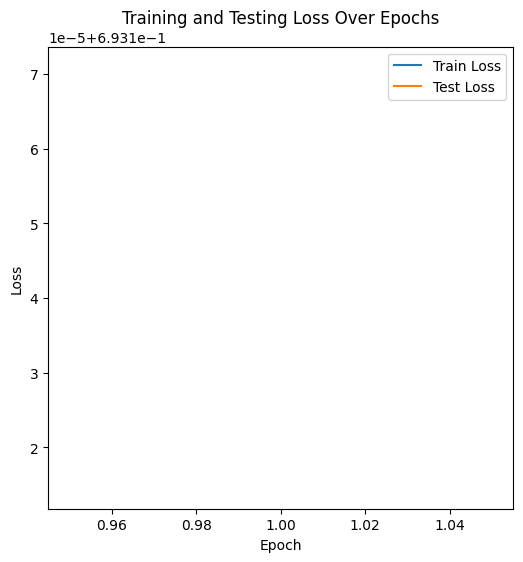

Model saved as 'model/final v3/model_input20_target2_dropout0.2.pth' at Epoch 2
Epoch 2/100, Train Loss: 0.6931122366617639, Test Loss: 0.6931707995704637 completed in 0h:7m:14s. Estimated time remaining: 11h:50m:23s.


<Figure size 640x480 with 0 Axes>

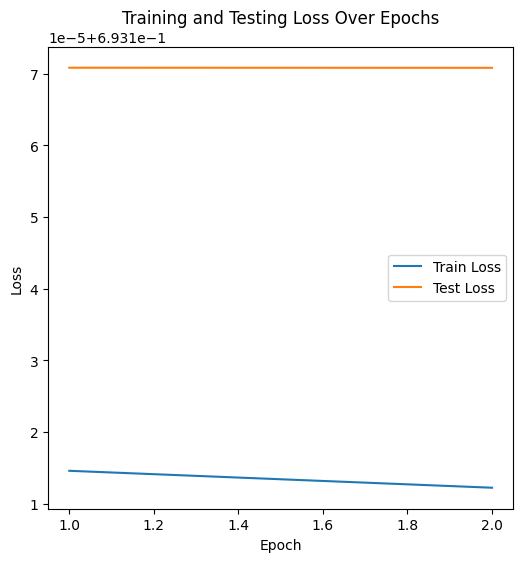

Epoch 3/100, Train Loss: 0.6931122366034346, Test Loss: 0.6931707995704637 completed in 0h:6m:16s. Estimated time remaining: 10h:9m:25s.


<Figure size 640x480 with 0 Axes>

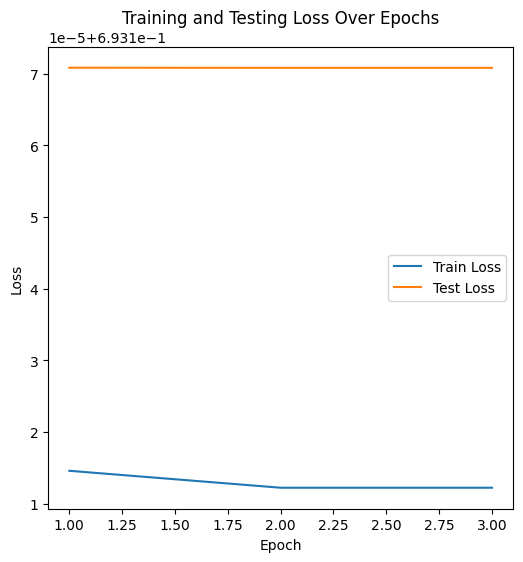

Epoch 4/100, Train Loss: 0.6931122366034346, Test Loss: 0.6931707995704637 completed in 0h:5m:52s. Estimated time remaining: 9h:23m:28s.


<Figure size 640x480 with 0 Axes>

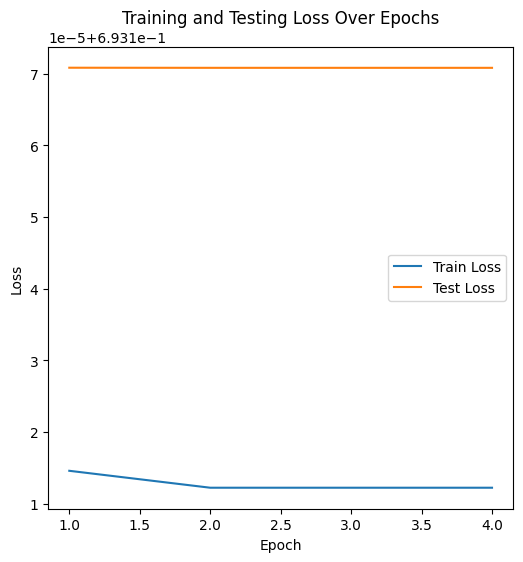

Epoch 5/100, Train Loss: 0.6931122366034346, Test Loss: 0.6931707995704637 completed in 0h:5m:52s. Estimated time remaining: 9h:17m:49s.


<Figure size 640x480 with 0 Axes>

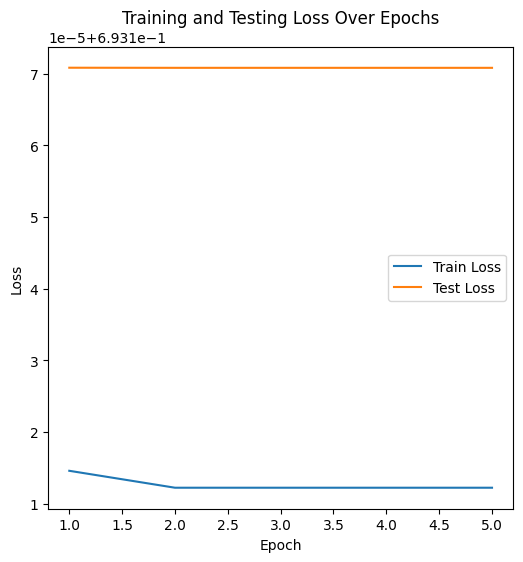

Epoch 6/100, Train Loss: 0.6931122366034346, Test Loss: 0.6931707995704637 completed in 0h:5m:50s. Estimated time remaining: 9h:8m:56s.


<Figure size 640x480 with 0 Axes>

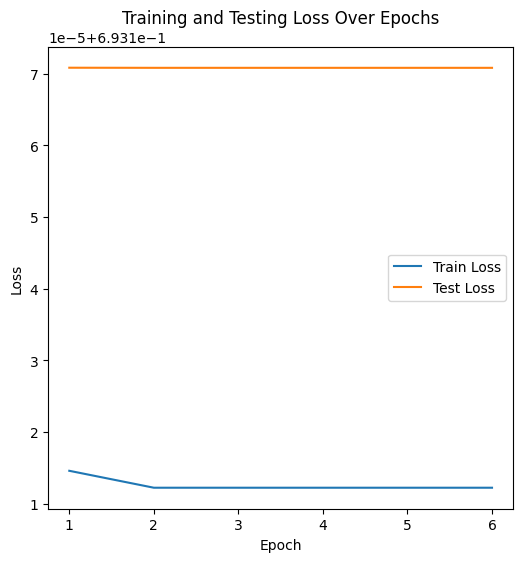

Epoch 7/100, Train Loss: 0.6931122366034346, Test Loss: 0.6931707995704637 completed in 0h:6m:14s. Estimated time remaining: 9h:41m:8s.


<Figure size 640x480 with 0 Axes>

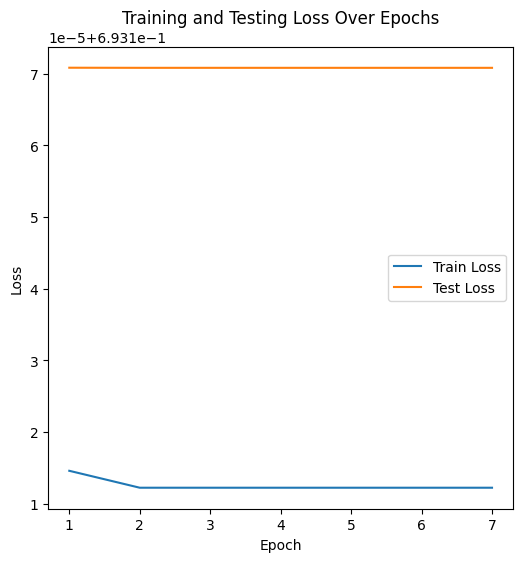

Epoch 8/100, Train Loss: 0.6931122366034346, Test Loss: 0.6931707995704637 completed in 0h:6m:28s. Estimated time remaining: 9h:55m:43s.


<Figure size 640x480 with 0 Axes>

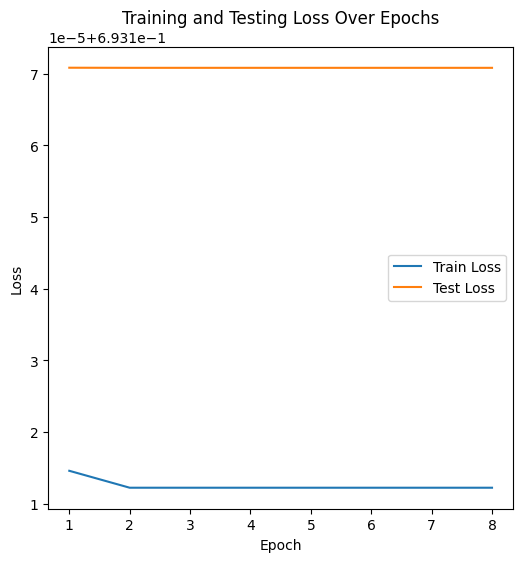

Epoch 9/100, Train Loss: 0.6931122366034346, Test Loss: 0.6931707995704637 completed in 0h:6m:32s. Estimated time remaining: 9h:54m:57s.


<Figure size 640x480 with 0 Axes>

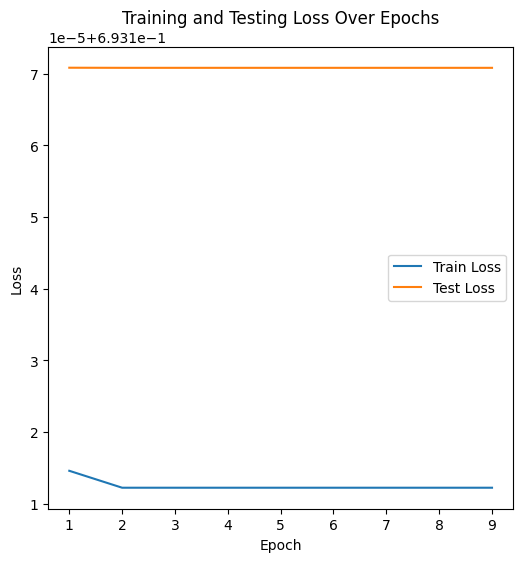

Epoch 10/100, Train Loss: 0.6931122366034346, Test Loss: 0.6931707995704637 completed in 0h:6m:30s. Estimated time remaining: 9h:45m:48s.


<Figure size 640x480 with 0 Axes>

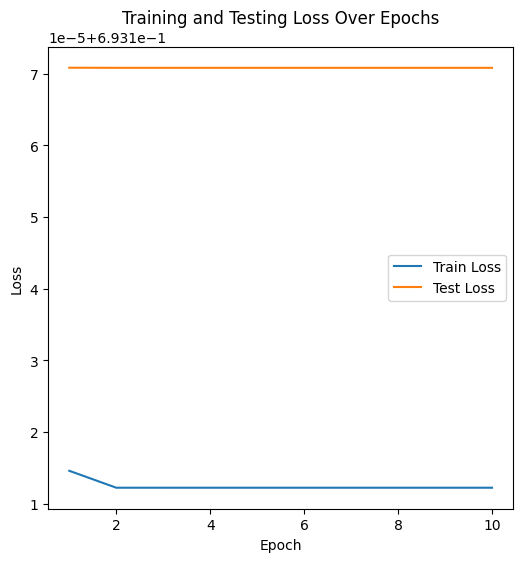

Epoch 11/100, Train Loss: 0.6931122366034346, Test Loss: 0.6931707995704637 completed in 0h:6m:33s. Estimated time remaining: 9h:43m:26s.


<Figure size 640x480 with 0 Axes>

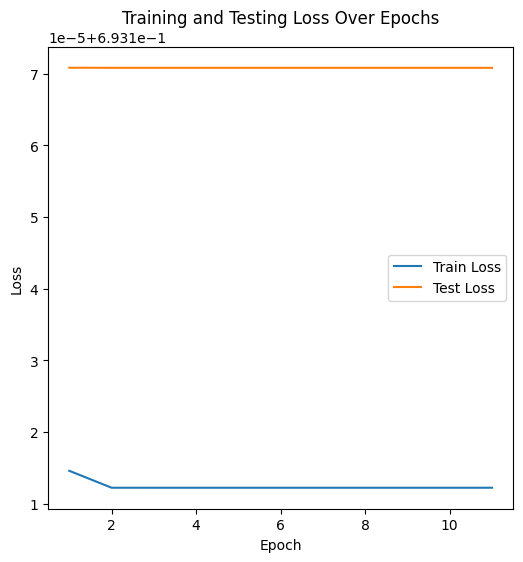

Epoch 12/100, Train Loss: 0.6931122366034346, Test Loss: 0.6931707995704637 completed in 0h:6m:34s. Estimated time remaining: 9h:38m:21s.


<Figure size 640x480 with 0 Axes>

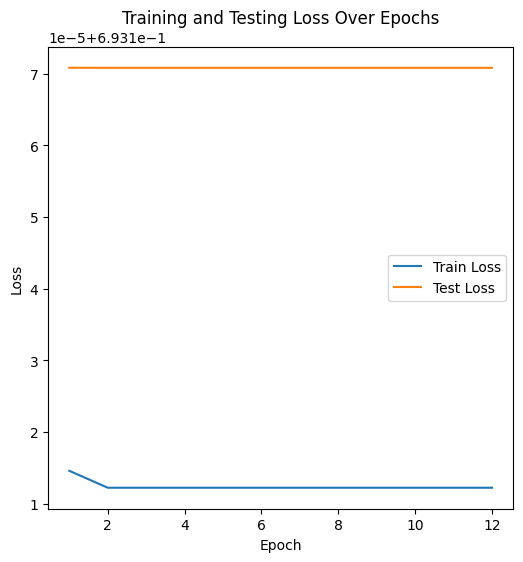

Epoch 13/100, Train Loss: 0.6931122366034346, Test Loss: 0.6931707995704637 completed in 0h:6m:34s. Estimated time remaining: 9h:32m:6s.


<Figure size 640x480 with 0 Axes>

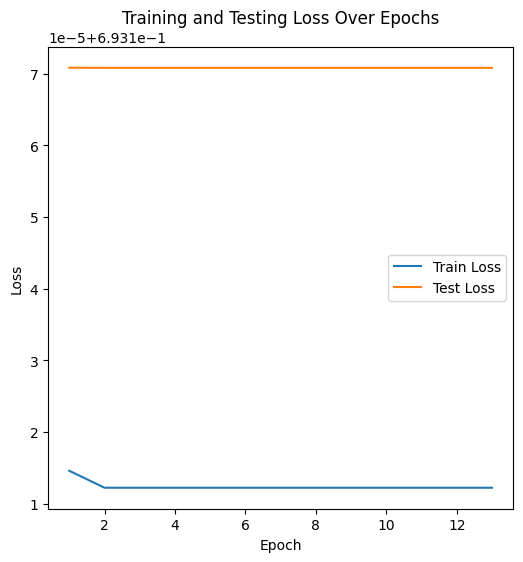

Epoch 14/100, Train Loss: 0.6931122366034346, Test Loss: 0.6931707995704637 completed in 0h:6m:33s. Estimated time remaining: 9h:24m:39s.


<Figure size 640x480 with 0 Axes>

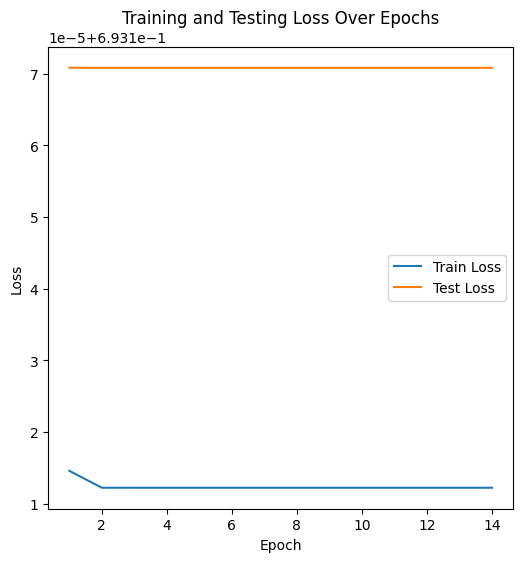

Epoch 15/100, Train Loss: 0.6931122366034346, Test Loss: 0.6931707995704637 completed in 0h:6m:28s. Estimated time remaining: 9h:10m:47s.


<Figure size 640x480 with 0 Axes>

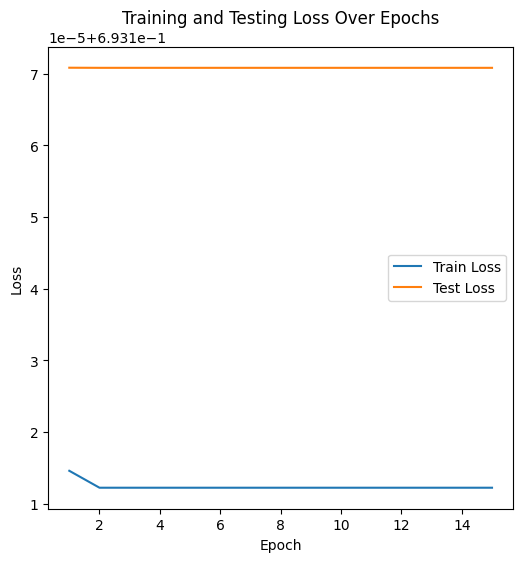

Epoch 16/100, Train Loss: 0.6931122366034346, Test Loss: 0.6931707995704637 completed in 0h:6m:16s. Estimated time remaining: 8h:46m:25s.


<Figure size 640x480 with 0 Axes>

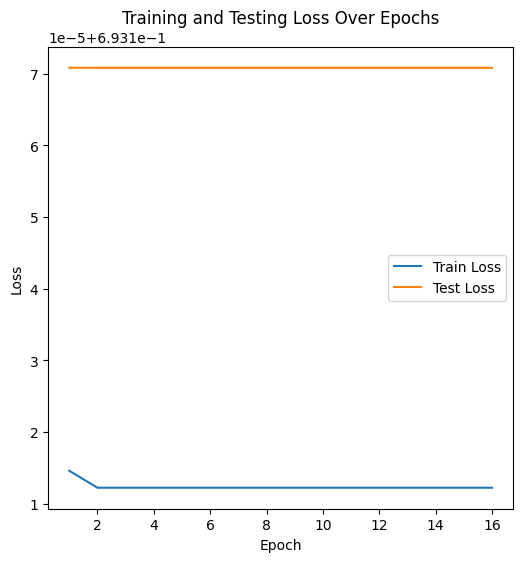

Epoch 17/100, Train Loss: 0.6931122366034346, Test Loss: 0.6931707995704637 completed in 0h:5m:58s. Estimated time remaining: 8h:15m:25s.


<Figure size 640x480 with 0 Axes>

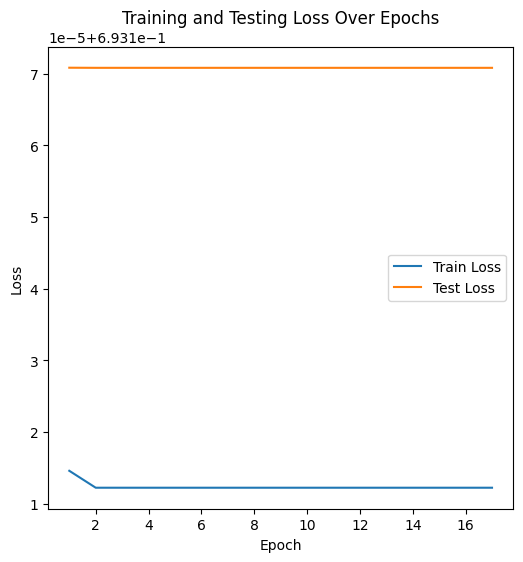

Epoch 18/100, Train Loss: 0.6931122366034346, Test Loss: 0.6931707995704637 completed in 0h:6m:27s. Estimated time remaining: 8h:50m:0s.


<Figure size 640x480 with 0 Axes>

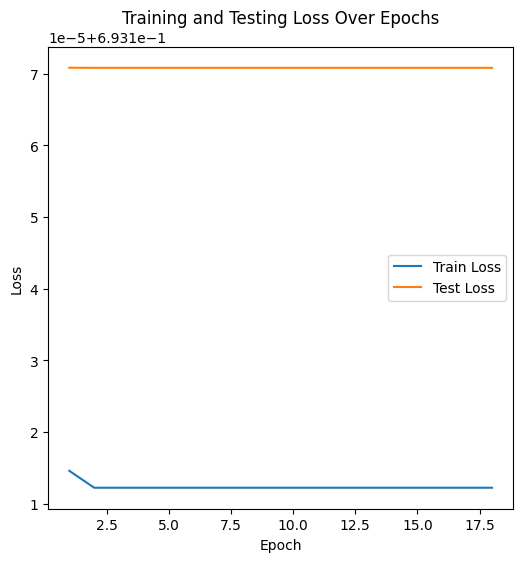

Epoch 19/100, Train Loss: 0.6931122366034346, Test Loss: 0.6931707995704637 completed in 0h:6m:35s. Estimated time remaining: 8h:54m:3s.


<Figure size 640x480 with 0 Axes>

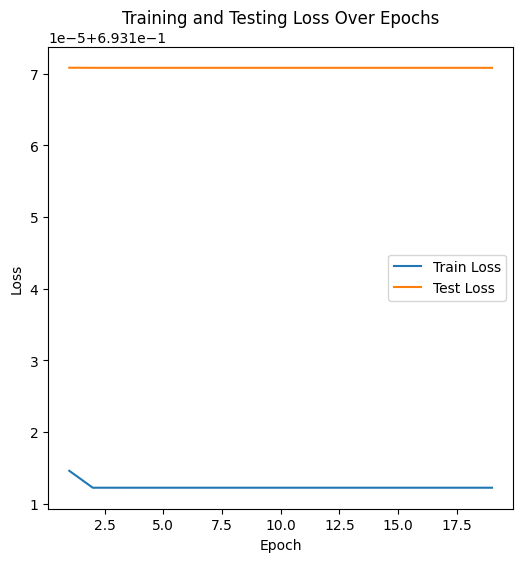

Epoch 20/100, Train Loss: 0.6931122366034346, Test Loss: 0.6931707995704637 completed in 0h:6m:31s. Estimated time remaining: 8h:42m:39s.


<Figure size 640x480 with 0 Axes>

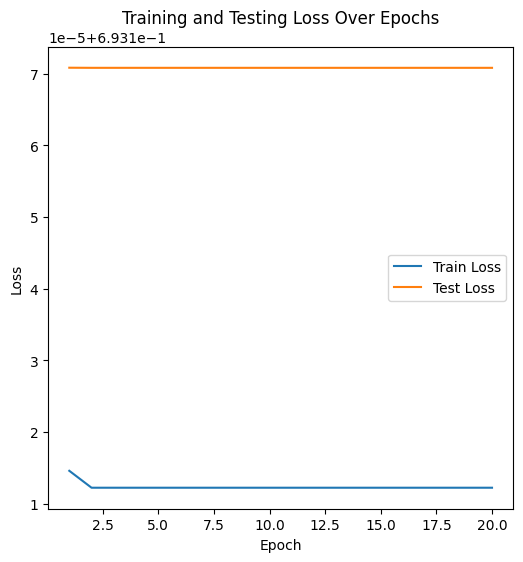

Epoch 21/100, Train Loss: 0.6931122366034346, Test Loss: 0.6931707995704637 completed in 0h:6m:35s. Estimated time remaining: 8h:40m:57s.


<Figure size 640x480 with 0 Axes>

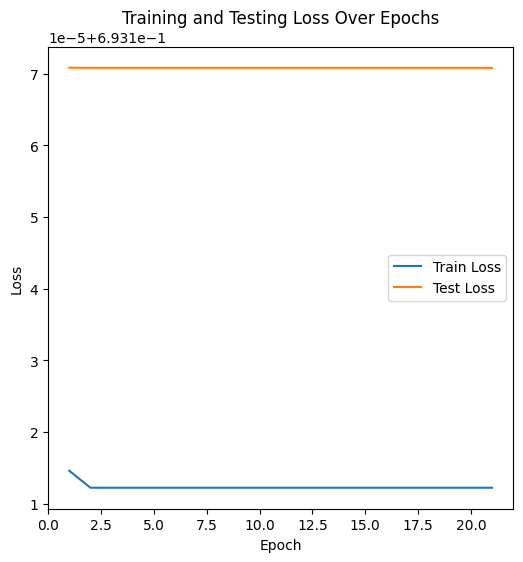

Epoch 22/100, Train Loss: 0.6931122366034346, Test Loss: 0.6931707995704637 completed in 0h:6m:35s. Estimated time remaining: 8h:34m:39s.


<Figure size 640x480 with 0 Axes>

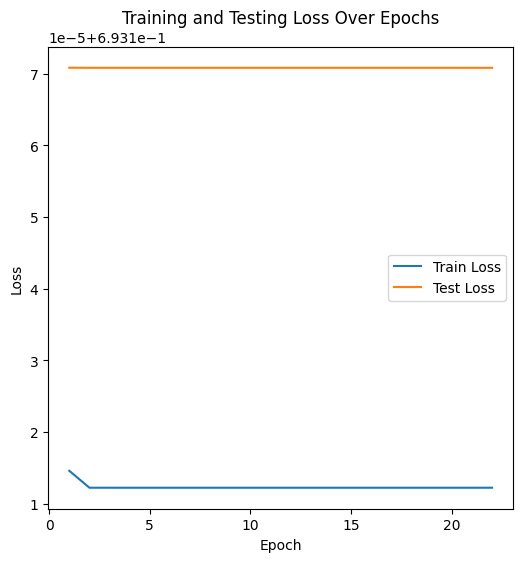

Epoch 23/100, Train Loss: 0.6931122366034346, Test Loss: 0.6931707995704637 completed in 0h:6m:37s. Estimated time remaining: 8h:29m:56s.


<Figure size 640x480 with 0 Axes>

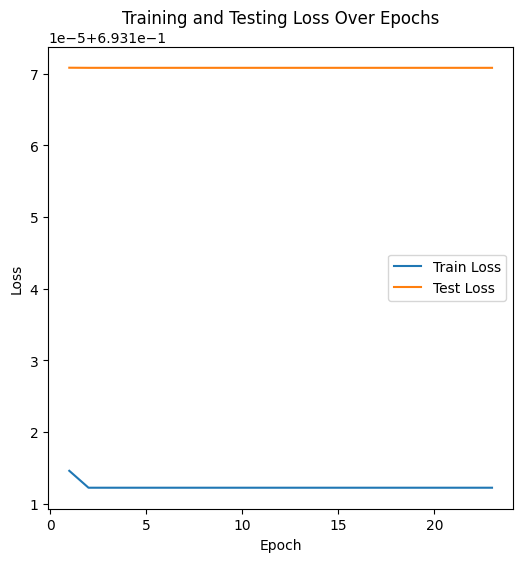

Epoch 24/100, Train Loss: 0.6931122366034346, Test Loss: 0.6931707995704637 completed in 0h:6m:37s. Estimated time remaining: 8h:23m:42s.


<Figure size 640x480 with 0 Axes>

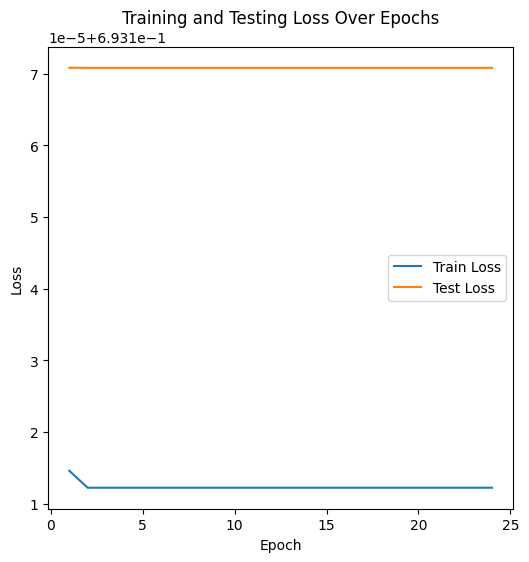

Epoch 25/100, Train Loss: 0.6931122366034346, Test Loss: 0.6931707995704637 completed in 0h:6m:35s. Estimated time remaining: 8h:14m:22s.


<Figure size 640x480 with 0 Axes>

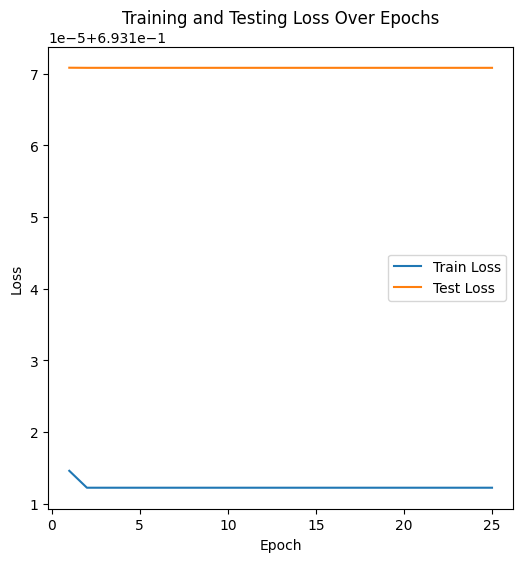

Epoch 26/100, Train Loss: 0.6931122366034346, Test Loss: 0.6931707995704637 completed in 0h:6m:22s. Estimated time remaining: 7h:51m:54s.


<Figure size 640x480 with 0 Axes>

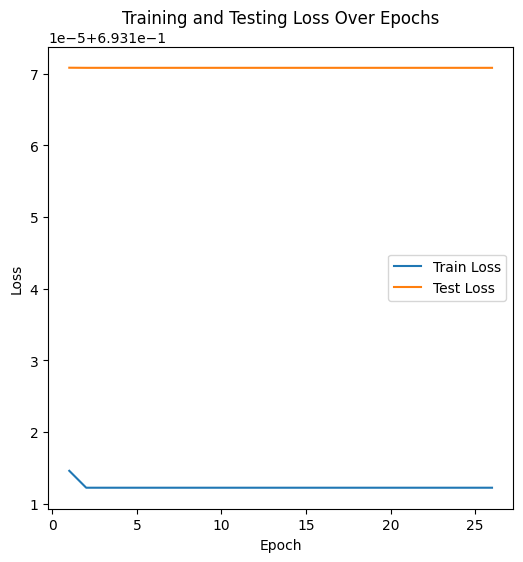

Epoch 27/100, Train Loss: 0.6931122366034346, Test Loss: 0.6931707995704637 completed in 0h:6m:24s. Estimated time remaining: 7h:47m:16s.


<Figure size 640x480 with 0 Axes>

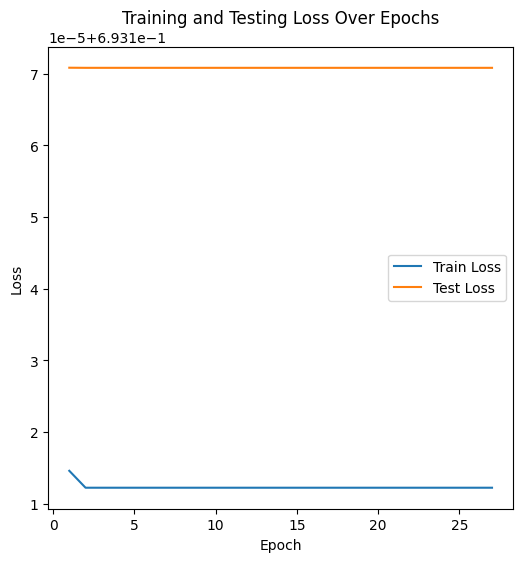

Epoch 28/100, Train Loss: 0.6931122366034346, Test Loss: 0.6931707995704637 completed in 0h:6m:23s. Estimated time remaining: 7h:40m:31s.


<Figure size 640x480 with 0 Axes>

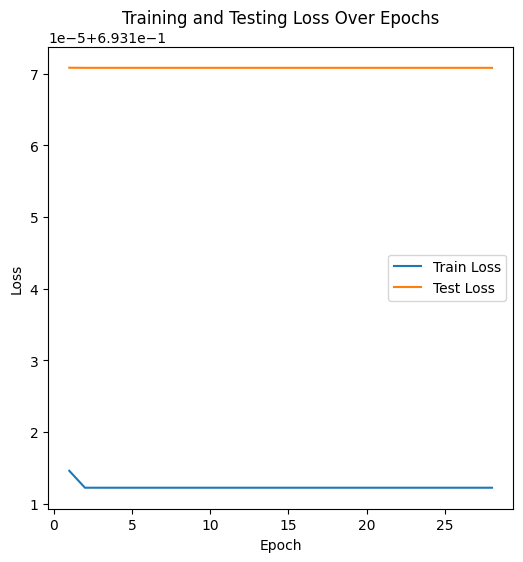

Epoch 29/100, Train Loss: 0.6931122366034346, Test Loss: 0.6931707995704637 completed in 0h:6m:22s. Estimated time remaining: 7h:33m:0s.


<Figure size 640x480 with 0 Axes>

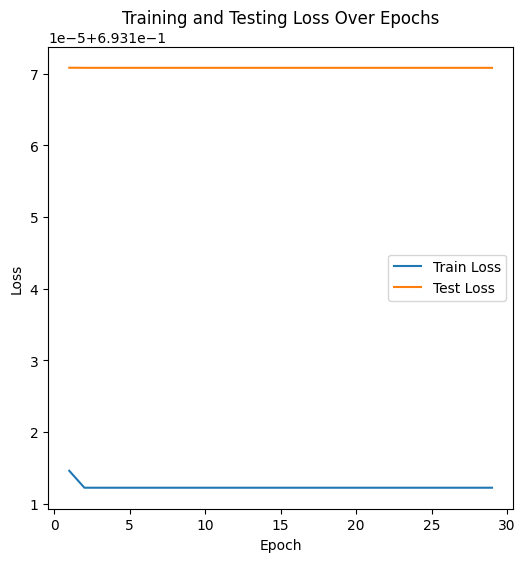

Epoch 30/100, Train Loss: 0.6931122366034346, Test Loss: 0.6931707995704637 completed in 0h:6m:24s. Estimated time remaining: 7h:28m:37s.


<Figure size 640x480 with 0 Axes>

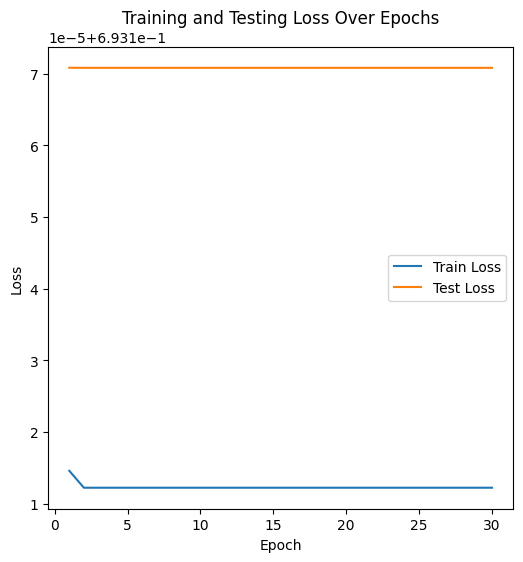

Epoch 31/100, Train Loss: 0.6931122366034346, Test Loss: 0.6931707995704637 completed in 0h:6m:23s. Estimated time remaining: 7h:20m:51s.


<Figure size 640x480 with 0 Axes>

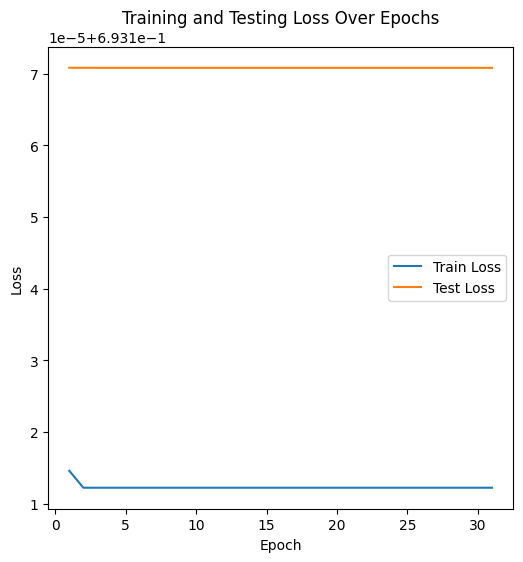

Epoch 32/100, Train Loss: 0.6931122366034346, Test Loss: 0.6931707995704637 completed in 0h:6m:24s. Estimated time remaining: 7h:15m:30s.


<Figure size 640x480 with 0 Axes>

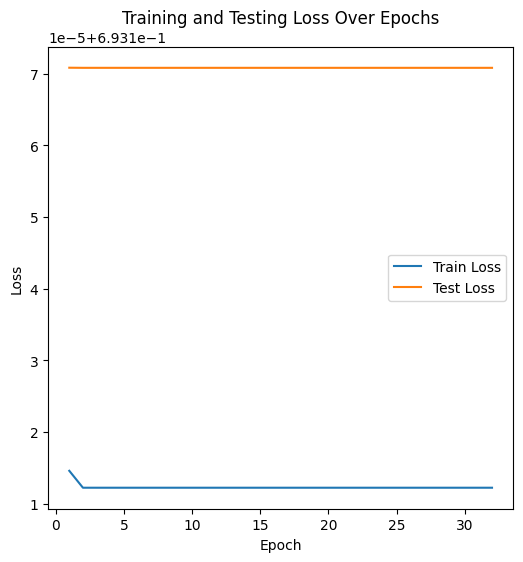

Epoch 33/100, Train Loss: 0.6931122366034346, Test Loss: 0.6931707995704637 completed in 0h:6m:24s. Estimated time remaining: 7h:9m:49s.


<Figure size 640x480 with 0 Axes>

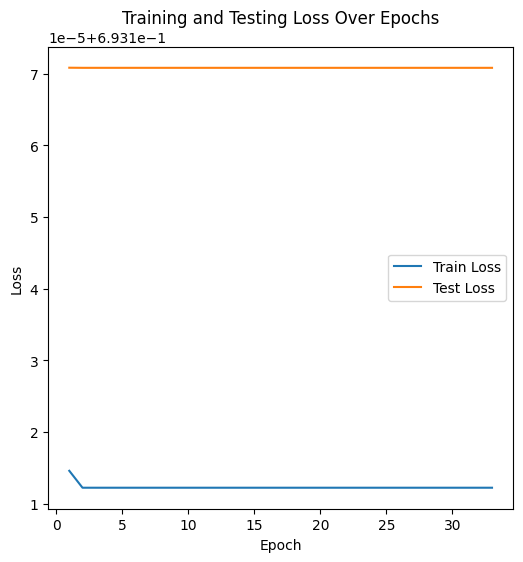

Epoch 34/100, Train Loss: 0.6931122366034346, Test Loss: 0.6931707995704637 completed in 0h:6m:21s. Estimated time remaining: 6h:59m:19s.


<Figure size 640x480 with 0 Axes>

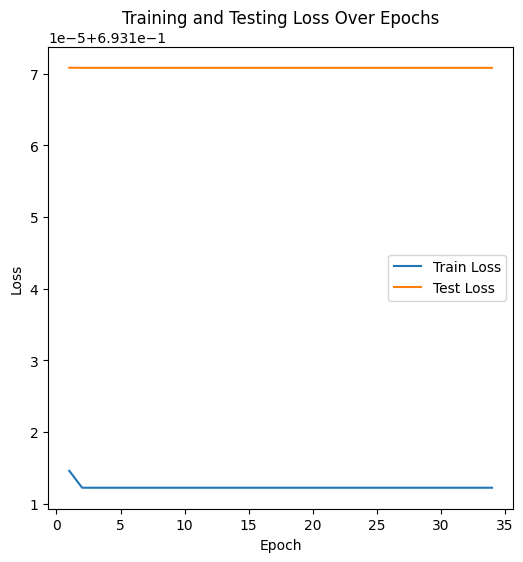

Epoch 35/100, Train Loss: 0.6931122366034346, Test Loss: 0.6931707995704637 completed in 0h:6m:24s. Estimated time remaining: 6h:56m:47s.


<Figure size 640x480 with 0 Axes>

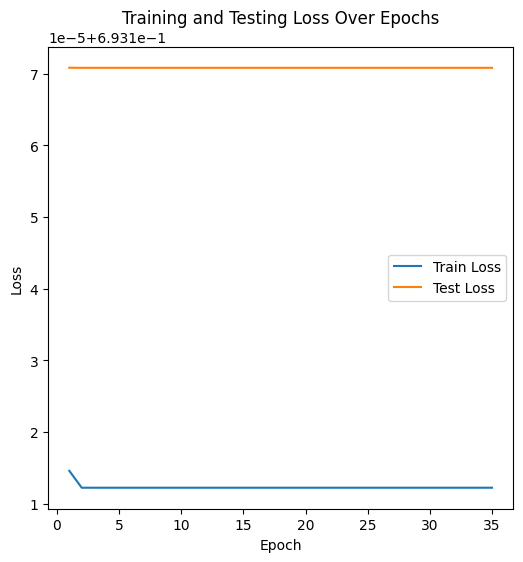

Epoch 36/100, Train Loss: 0.6931122366034346, Test Loss: 0.6931707995704637 completed in 0h:6m:25s. Estimated time remaining: 6h:51m:31s.


<Figure size 640x480 with 0 Axes>

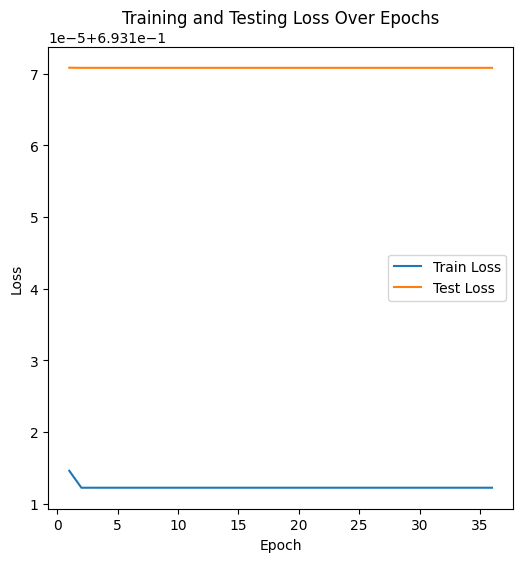

Epoch 37/100, Train Loss: 0.6931122366034346, Test Loss: 0.6931707995704637 completed in 0h:6m:23s. Estimated time remaining: 6h:43m:5s.


<Figure size 640x480 with 0 Axes>

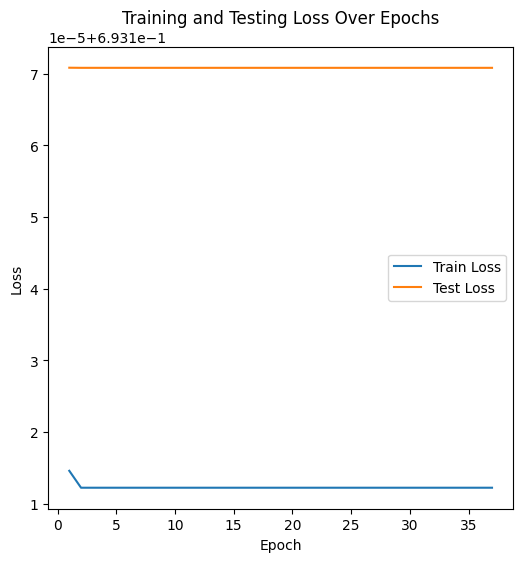

Epoch 38/100, Train Loss: 0.6931122366034346, Test Loss: 0.6931707995704637 completed in 0h:6m:24s. Estimated time remaining: 6h:37m:27s.


<Figure size 640x480 with 0 Axes>

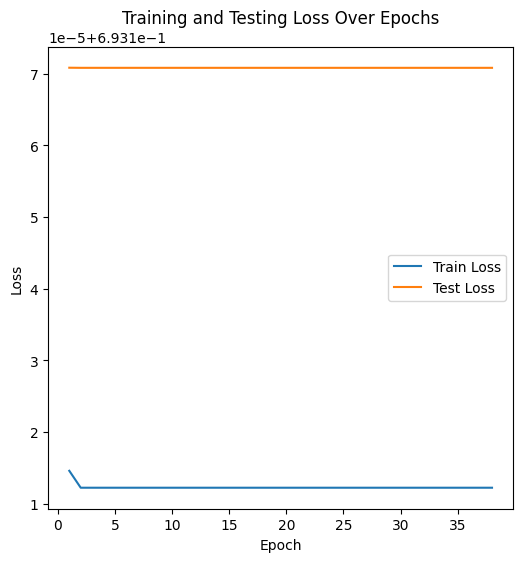

Epoch 39/100, Train Loss: 0.6931122366034346, Test Loss: 0.6931707995704637 completed in 0h:6m:23s. Estimated time remaining: 6h:29m:27s.


<Figure size 640x480 with 0 Axes>

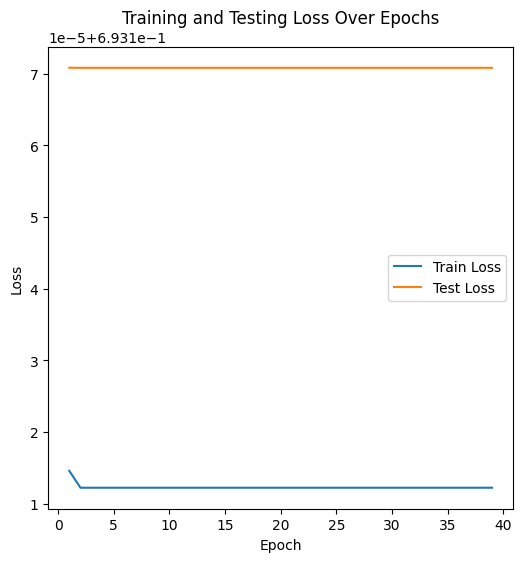

Epoch 40/100, Train Loss: 0.6931122366034346, Test Loss: 0.6931707995704637 completed in 0h:6m:22s. Estimated time remaining: 6h:22m:16s.


<Figure size 640x480 with 0 Axes>

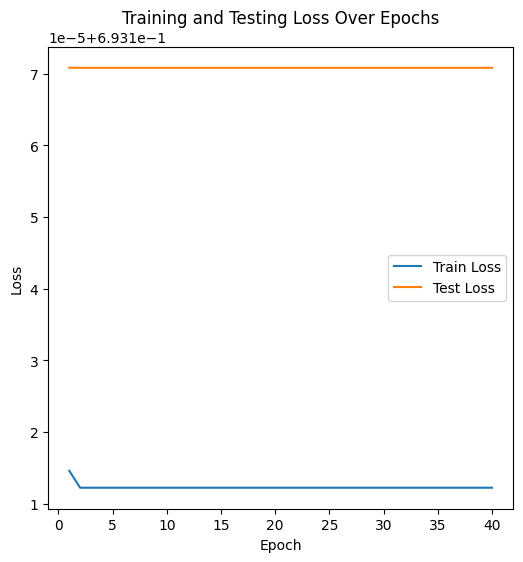

Epoch 41/100, Train Loss: 0.6931122366034346, Test Loss: 0.6931707995704637 completed in 0h:6m:22s. Estimated time remaining: 6h:16m:14s.


<Figure size 640x480 with 0 Axes>

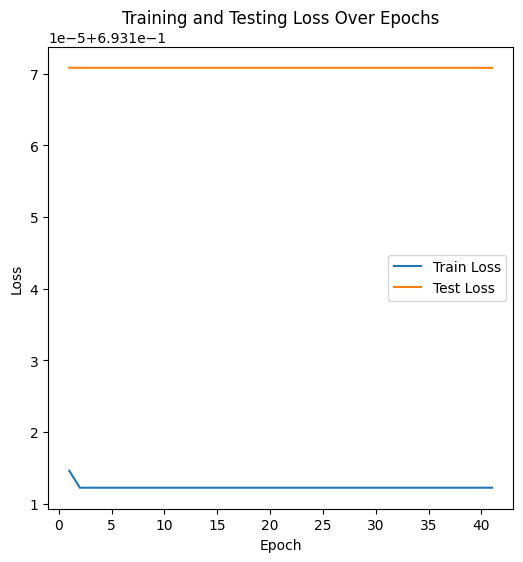

Epoch 42/100, Train Loss: 0.6931122366034346, Test Loss: 0.6931707995704637 completed in 0h:6m:21s. Estimated time remaining: 6h:8m:54s.


<Figure size 640x480 with 0 Axes>

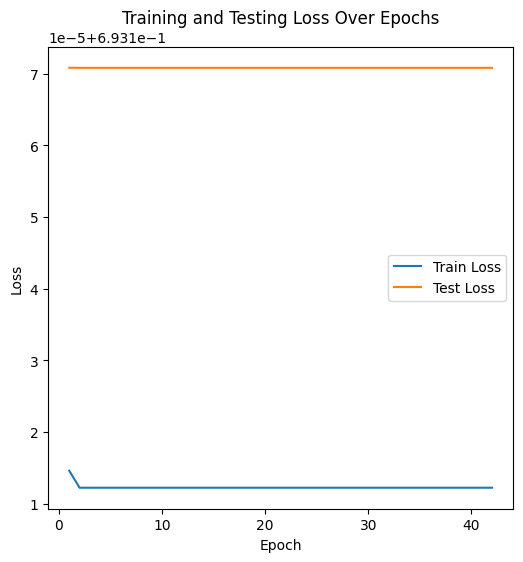

Epoch 43/100, Train Loss: 0.6931122366034346, Test Loss: 0.6931707995704637 completed in 0h:6m:22s. Estimated time remaining: 6h:3m:19s.


<Figure size 640x480 with 0 Axes>

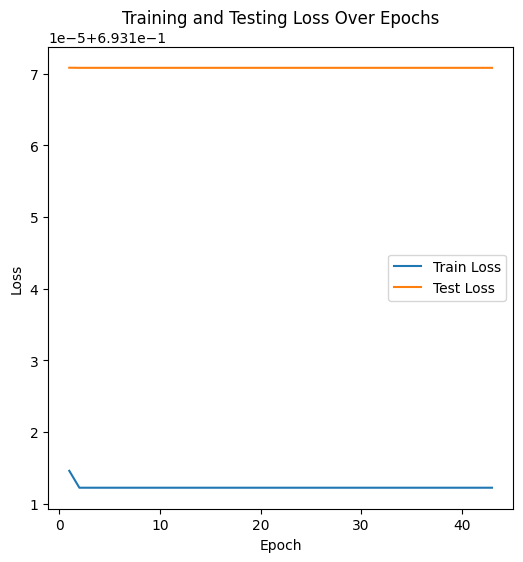

Epoch 44/100, Train Loss: 0.6931122366034346, Test Loss: 0.6931707995704637 completed in 0h:6m:22s. Estimated time remaining: 5h:57m:15s.


<Figure size 640x480 with 0 Axes>

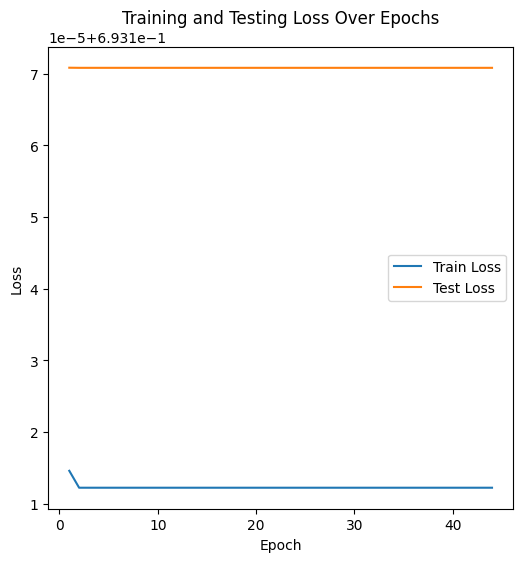

Epoch 45/100, Train Loss: 0.6931122366034346, Test Loss: 0.6931707995704637 completed in 0h:6m:24s. Estimated time remaining: 5h:52m:30s.


<Figure size 640x480 with 0 Axes>

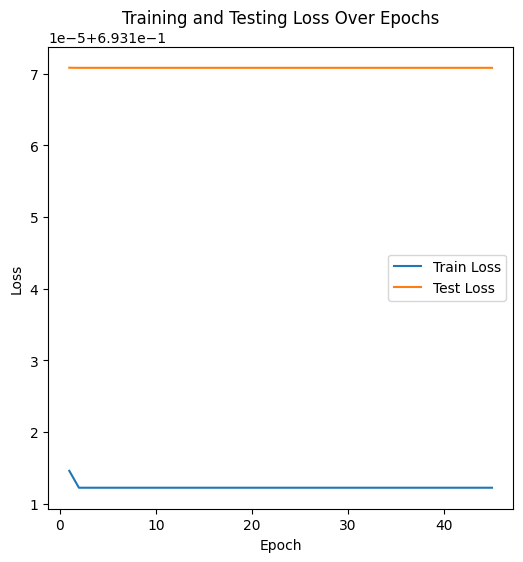

Epoch 46/100, Train Loss: 0.6931122366034346, Test Loss: 0.6931707995704637 completed in 0h:6m:23s. Estimated time remaining: 5h:44m:43s.


<Figure size 640x480 with 0 Axes>

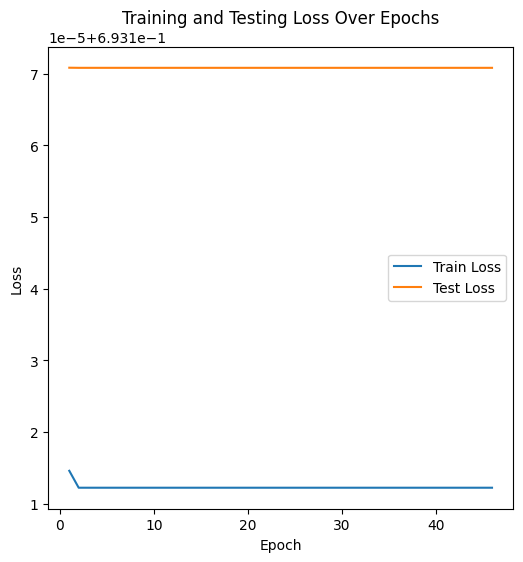

Epoch 47/100, Train Loss: 0.6931122366034346, Test Loss: 0.6931707995704637 completed in 0h:6m:23s. Estimated time remaining: 5h:38m:36s.


<Figure size 640x480 with 0 Axes>

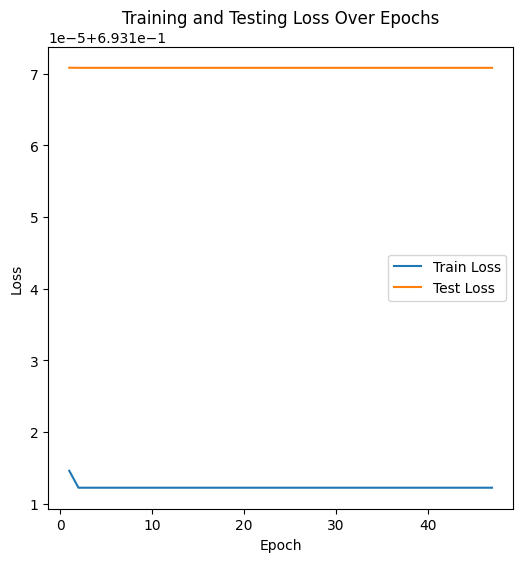

: 

In [16]:
def create_model_filename(input_size, target_size, dropout_rate):
    return f"model_input{input_size}_target{target_size}_dropout{dropout_rate}.pth"

# 모델 파일 경로
model_file_path = f"model/final v3/{create_model_filename(input_size, target_size, dropout_rate)}"

# 모델 파일이 존재하는지 확인하고, 존재할 경우 모델 로드
if os.path.isfile(model_file_path):
    model.load_state_dict(torch.load(model_file_path))
    print("Pre-trained model loaded.")
else:
    print("No pre-trained model found. Initializing a new model.")

# 학습 과정
train_losses = []
test_losses = []
best_test_loss = float('inf')

# Define the directory for saving figures
figures_directory = "figures/final v3"
model_name = create_model_filename(input_size, target_size, dropout_rate=dropout_rate).replace('.pth', '')  # Use the generated model name without the file extension
model_figures_directory = os.path.join(figures_directory, model_name)

# Create the directories if they do not exist
os.makedirs(model_figures_directory, exist_ok=True)

def format_time(seconds):
    hours = int(seconds // 3600)
    minutes = int((seconds % 3600) // 60)
    seconds = int(seconds % 60)
    return f"{hours}h:{minutes}m:{seconds}s"

for epoch in range(num_epochs):
    start_time = time.time()

    train_loss = train(model, train_loader, optimizer, criterion)
    test_loss = test(model, test_loader, criterion)

    train_losses.append(train_loss)
    test_losses.append(test_loss)

    # Update best test loss and save model
    if test_loss < best_test_loss:
        best_test_loss = test_loss
        torch.save(model.state_dict(), model_file_path)  # Corrected this line
        print(f"Model saved as '{model_file_path}' at Epoch {epoch + 1}")

    end_time = time.time()
    epoch_duration = end_time - start_time
    remaining_time = epoch_duration * (num_epochs - epoch - 1)

    formatted_duration = format_time(epoch_duration)
    formatted_remaining = format_time(remaining_time)

    # Print epoch results
    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss}, Test Loss: {test_loss} completed in {formatted_duration}. Estimated time remaining: {formatted_remaining}.")

    # Plotting
    plt.figure(figsize=(6, 6))
    plt.plot(range(1, epoch + 2), train_losses, label='Train Loss')
    plt.plot(range(1, epoch + 2), test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Testing Loss Over Epochs')
    plt.legend()

    # Save and show the figure
    figure_path = os.path.join(model_figures_directory, f"Epoch_{epoch+1}.png")
    plt.savefig(figure_path)
    plt.show()
    plt.clf()
